In [1]:
import numpy as np

import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

A note on what VEGAS tries to do.

We have to calculate $I=\int_{0}^{1}dx f(x)$ and we want to do it in Monte Carlo.
We know that the variance is minimized if we sample from $p(x) \sim |f(x)|$.

What we do is to break the integration interval in N bins. In each bin we sample uniformly (the same number of sample in each bin). Now, if the bin-sizes are small in the regions that the integral has large contributions, then we effectivelly sample from $\sim |f(x)|$ (that is the most important regions get more points!).

VEGAS, iterativelly, tries to adjust each bin-size, so that the more important regions get smaller binsizes!
See next comment on how the grid is updated.

A commend on how the grid is updated:

First, calculate $m_{i} \equiv \frac{\int_{x_{i}}^{x_{i+1}} dx |f(x)|}{\int_{0}^{1} dx |f(x)|}$  (for smoother convergence we pass the weights from a function, $G$, of the form $m_{i} \to K \times 
G\left[ m_i \right]^{\alpha}$)

These $m$'s weigh how important the $i^{th}$ bin is. So we could subdevide each bin to $m_{i}+1$ sub-bins 
and then sample uniformly in each oe of them. However this would be extremely slow.
%
So,we need to merge some of them to restore the original number of bins (N). To do this in a way 
that  we'll effectively approximate $|f(x)|$, we redefine the new $\Delta x's$ as:

$$
\dfrac{\frac{\Delta x_{i}}{m_{i}+1}}{\frac{\Delta x_{i+1}}{m_{i+1}+1}}=\frac{\Delta x_{i}^{\prime}}{\Delta x_{i+1}^{\prime}}
$$

In this way, we keep the relative density of the $m_{i}+1$ sub-divisions of each bin! 
The constraint in orde to do this consistently (we integrate in [0,1]) is:

$$
\sum \limits_{i=0}^{N-1} \Delta x_{i}^{\prime} =1
$$

The equations above give us
$$
\Delta x_{i}^{\prime}=\frac{\Delta x_{i}}{\Delta x_{0}} \frac{m_{0}+1}{m_{i}+1}\Delta x_{0}^{\prime}
$$


and

$$
\Delta x_{0}^{\prime}=\frac{\Delta x_{0}}{m_{0}+1}
\left( \sum \limits_{i=0}^{N-1} \frac{\Delta x_{i}}{m_{i}+1} \right)^{-1}
$$

NOTE: When the algorithm converges, i.e $\Delta x_{i}^{\prime} \approx \Delta x_{i}$, 
then you can see that $ \frac{m_{i}+1}{m_{0}+1} \approx 1$. That is, VEGAS effectively
breaks the interal of integration in such way that all bins contribute the same!


Basically, that's it. The implementation of VEGAS for the most part is straightforward.




---

For D-dimensions the only thing that really changes is that the distribution function and the definition of the weights. The distribution is defined as 

$$
p(\vec x) = p^{(0)}(x^{0}) \times p^{(1)}(x^{(1)})\times \dots\times  p^{(D)}(x^{(D)}) \;,
$$

where for each dimention you take bins as in 1D. 

The weights in D-dimensions are
$$
m_{\rm bin}^{\rm (dim)} = \dfrac{ \int_{x_{\rm bin}^{\rm (dim)}}^{x_{\rm bin+1}^{\rm (dim)}}dx^{\rm (dim)} \int_{0}^{1} d^{D-1}x|f(\vec x)| }{ \int_{0}^{1} d^{D}x|f(\vec x)| } \;,
$$
that is, for each bin of some dim you average over all other dimensions.  

In [2]:
class VEGAS:
    def __init__(self, NDim , NBin , function,  NPoints,  NBatches, 
                       NAdapts,  AdaptPoints,  constK=1,  alpha=0.9):
        #Number of dimentions
        self.NDim=NDim 
        #Number of bins
        self.NBin=NBin 
        
        #this is the function. It sould take one point of dimension NDim and return 
        #the result (for NDim=1, the point is a list of length 1)
        self.Integrand=function
        
        #Number of points to take when evaluating the integral
        self.NPoints=NPoints
        #Number of Batches to run
        self.NBatches=NBatches
        
        #Number of adaptation iterations
        self.NAdapts=NAdapts
        #Number of points to take when evaluating the weights 
        self.AdaptPoints=AdaptPoints
        
        #The constK increases the difference between the small and the large weights.
        self.constK=constK
        
        #The exponent regulates the weights. See  UpdateBins()        
        self.alpha=alpha
        
        
        self.weights = [[0   for i in range(NBin)]  for j in range(NDim) ]
        self.Grid = [[0   for i in range(NBin+1)]  for j in range(NDim) ]
        
        for dim in range( NDim):
            self.Grid[dim][0]=0
            
            for bin in  range(1,NBin+1):
                self.Grid[dim][bin]= self.Grid[dim][bin-1] + 1./float(NBin)
        
        
        
        
    
    def Random(self,min,max):
        '''get a random point in [min,max]'''
        return np.random.rand()*(max - min) + min
    
    def RandomBin(self):
        '''get random bin'''
        return np.random.randint(NBin)
    
    def PartialIntegrals(self):
        '''Claculate the partial integrals. Returns \int|f|*NPoints. This is what we need to 
            get the regulated weights.
            
        '''
        
        bins=[0 for i in range(self.NDim)]
        point=[0 for i in range(self.NDim)]
        AbsInt=0
        
        for _np in range(self.AdaptPoints):
            inv_dist=1
            
            for dim in range(self.NDim):
                bins[dim]=self.RandomBin()
                point[dim] = self.Random( self.Grid[dim][bins[dim]] , self.Grid[dim][bins[dim]+1] ) 
                inv_dist*= self.NBin*(self.Grid[dim][bins[dim]+1] - self.Grid[dim][bins[dim]])
            
            FuncPoint=self.Integrand(point)
            AbsInt +=  np.abs(FuncPoint) * inv_dist
                
            for dim in range(self.NDim):
                self.weights[dim][bins[dim]]+= np.abs(FuncPoint) * inv_dist;
        
        return AbsInt
    
    def UpdateBins(self):
        '''Update the bins'''
        AbsInt = self.PartialIntegrals()
        binsizes= [0  for i in range(self.NBin)]
    
        for dim in range(self.NDim):
            dx0=0
            
            #The constK increases the difference between the small and the large weights. 
            #all new gridpoints are calculated in reference to weght[dim][0]. So keep only this, and reset all others at the end of the dim loop.
            w0=1.+ (1.+self.weights[dim][0]/AbsInt * np.log(self.constK*self.weights[dim][0]/AbsInt + 1. ) )**(self.alpha)
            for bin in  range(self.NBin):
                
                binsizes[bin]=self.Grid[dim][bin+1]-self.Grid[dim][bin]
                self.weights[dim][bin]=1.+ (1.+self.weights[dim][bin]/AbsInt * np.log(self.constK*self.weights[dim][bin]/AbsInt + 1. ) )**(self.alpha)
                
                dx0+=w0/binsizes[0]*(binsizes[bin]/self.weights[dim][bin])
            
            dx0=1./dx0
            
            self.Grid[dim][0]=0
            for bin in  range(self.NBin):
                self.Grid[dim][bin+1]=self.Grid[dim][bin]+ dx0*binsizes[bin]/self.weights[dim][bin]*w0/binsizes[0]
                self.weights[dim][bin]=0 # You no longer need this weight. It is only used for  Grid[dim][bin+1]
                
            
            
            
            
    #  I take the total integral as follows.
    #  First, I don't want to go into every bin to take the same amount of points for every bin.
    #  So I just take NPoints and each point just contributes f(x)/p(x). To take
    #  NPoints quickly, I run a loop and I just choose a random bin for each dim.
    #  Here, 1/p(x) is calculated at the same time you find the point, sine it is just 
    #  (number of bins)*(binsize of the selected bin).
    def IntegrateTot(self):
        '''Calculate the integral in [0,1]'''
        IntMean=0
        IntVariance=0
        point=[0 for i in range(self.NDim)]

        for _np in range(self.NPoints):
            inv_dist=1
            
            for dim in range(self.NDim):
                bin=self.RandomBin();
                point[dim] = self.Random( self.Grid[dim][bin] , self.Grid[dim][bin+1] ); 
                inv_dist*=self.NBin*(self.Grid[dim][bin+1] - self.Grid[dim][bin]);
            
            FuncPoint=self.Integrand( point )
            Int_i=FuncPoint * inv_dist #contribution to the integral: f(x_i)/p(x_i)
            
            IntMean +=  Int_i/float(NPoints)
            IntVariance += Int_i**2/float(NPoints)
            
        # This should be positive, but when IntVariance=IntMean**2., we can loose precission, and get 
        # a very small negative number for the variance          
        IntVariance=np.abs( IntVariance - IntMean**2. )/(NPoints-1) 

        return IntMean, IntVariance
    
    
    def IntegrateBatch(self):
        ''' Use this to take batches. 
            It returns the integral estimate, its sigma (sqrt(var)), and 
            chi^2/(NBathes-1) which should be close to 1.'''
        SumI3Var=0 # To get Sum_b I^3/\sigma^2
        SumI2Var=0 # To get Sum_b I^2/\sigma^2

        SumInvVar=0 # To get Sum_b 1/var_b 
        SumI1Var=0  # To get Sum_b I_b/var_b
        
        for batch in range(self.NBatches):
            res,var=self.IntegrateTot()
            SumI2Var+=res**2/var;
            SumI3Var+=res**3/var;
            SumInvVar+=1/var;
            SumI1Var+=res/var;

        IntMean=SumI3Var/SumI2Var;
        IntSigma=IntMean/np.sqrt( SumI2Var)
        chi2=SumI2Var+(IntMean)**2*SumInvVar-2*SumI1Var*(IntMean) ;

        
        return IntMean , IntSigma , (chi2/(self.NBatches-1.))
        
    
    def Integrate(self):
        '''Combine everything together. First adapt, and then run  IntegrateBatch'''
        for n_adapt in range(self.NAdapts):
            self.UpdateBins()

        return  self.IntegrateBatch()
    
    
    #-----Auxiliary functions. You can remove them with no effect.-------#
    
    
    def Samples(self,N):
        '''Get N Samples from the Grid'''
        Samples=[[0   for i in range(N)]  for j in range(NDim) ]
        
        for _np in range(N):
            for dim in range(self.NDim):
                bin=self.RandomBin();
                Samples[dim][_np] = self.Random( self.Grid[dim][bin] , self.Grid[dim][bin+1] ); 
        return Samples
    


In [3]:
def f(x):
    return np.exp(-(x[0]-np.pi/4 )**2 *10 )*np.sin(x[0]*np.pi*3)*5 
#     return np.exp(-50*(x[0]-0.8)**2)

In [4]:
NDim=1
NBin=15

function=f

NPoints=1000
NBatches=30

NAdapts=50
AdaptPoints=500

constK=50
alpha=0.9

Integral=VEGAS(NDim , NBin , function,  NPoints,  NBatches, 
        NAdapts,  AdaptPoints,  constK, alpha)

In [5]:
result,sigma,R=Integral.Integrate()
print(
    "Result= ",result,'\n',
    "Relative sigma=", sigma/result*100, '% \n',
    'chi^2/(NBatch-1)=',R)

Result=  0.5407540416803693 
 Relative sigma= 1.6618190589334305 % 
 chi^2/(NBatch-1)= 0.8953430820676721


<IPython.core.display.Javascript object>


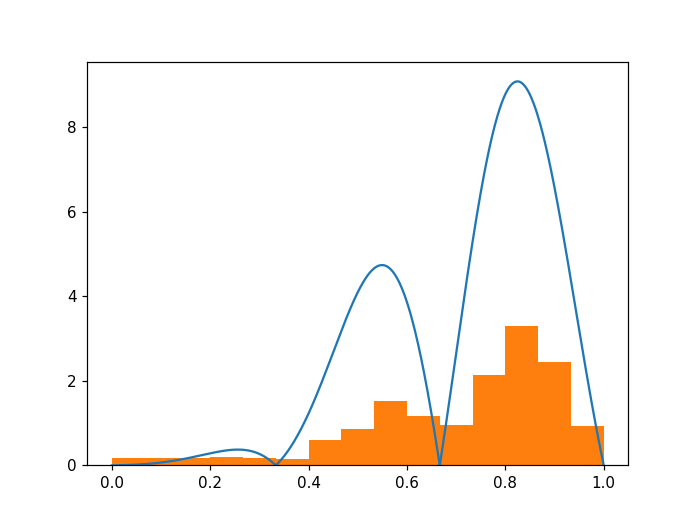

In [6]:
X=np.linspace(0,1,1000)

plt.plot(X, [ np.abs(f([x]))/result for x in X ]  )
plt.hist(Integral.Samples(20000)[0],bins=NBin,density=1)

plt.show()